In [1]:
from factor_analysis import *

# rqfactor 其他算子
from rqfactor import Factor, REF, MA, SUM, CS_ZSCORE,STD,PCT_CHANGE,CORR,DELTA,MAX,MIN
from rqfactor.extension import UserDefinedLeafFactor

# 文件输出
import pickle

# 关闭警告
import warnings
warnings.filterwarnings("ignore")
import logging
logging.getLogger().setLevel(logging.ERROR)

/home/rice/notebook/.packages/lib/python3.9/site-packages/rqdatac/client.py:206: UserWarning: rqdatac is already inited. Settings will be changed.
  warnings.warn("rqdatac is already inited. Settings will be changed.", stacklevel=0)


In [2]:
# 研究时间
start_date = '2018-01-01'   
end_date = '2024-01-01'       
# 研究标的
index_item = '000852.XSHG'            # 【example】：全A 000985.XSHG 中证1000 000852.XSHG

# 股票池
index_fix = INDEX_FIX(start_date,end_date,index_item)
# 获取日期 和 标的
stock_list = index_fix.columns.tolist()
date_list = index_fix.index.tolist()

### 1 因子库构建

#### 1.1 算子式构建

注意事项：

1. 因子的正负方向
2. 估值因子的非线性改造
3. 成长因子的分母异常

In [3]:
# 基本面因子  https://mp.weixin.qq.com/s/QDZp4UIhd_o6PBkWhP-usQ
## 全部资产现金回收率 = 经营性现金流/总资产
cfoa_mrq = Factor('cash_flow_from_operating_activities_mrq_0')/Factor('total_assets_mrq_0')
## 资产周转率变动 = 当期营业收入/当期总资产 - 去年同期营业收入/去年同期总资产
atdy_mrq = Factor('operating_revenue_mrq_0')/Factor('total_assets_mrq_0') - Factor('operating_revenue_mrq_4')/Factor('total_assets_mrq_4')
## 现金流动负债率比 = 经营性现金流/流动负债
ccr_mrq = Factor('cash_flow_from_operating_activities_mrq_0')/Factor('current_liabilities_mrq_0')
## 营业利润同比增长率 = （当期营业利润 - 去年同期营业利润）/绝对值（去年同期营业利润）
op_q_yoy_mrq = (Factor('profit_from_operation_mrq_0') - Factor('profit_from_operation_mrq_4'))/ABS(Factor('profit_from_operation_mrq_4'))
## 股息率
dp_ttm = Factor('dividend_yield_ttm')
## 市盈率
pe_ttm = Factor('market_cap_3')/Factor('net_profit_parent_company_lyr_0')
## 盈市率 = 1/市盈率
ep_ttm = Factor('net_profit_parent_company_lyr_0')/Factor('market_cap_3')
## 营业利润率 = 营业利润/营业收入
opr_mrq = Factor('profit_from_operation_mrq_0') / Factor('operating_revenue_mrq_0')

# 量价因子
HIGH = Factor('high')
LOW = Factor('low')
OPEN = Factor('open')
CLOSE = Factor('close')
VOLUME = Factor('volume')
TURNOVER = Factor('total_turnover')

def turnover_rate(order_book_ids,start_date,end_date):
    return get_turnover_rate(order_book_ids,start_date,end_date,fields='today').today.unstack('order_book_id').reindex(columns=order_book_ids,index =pd.to_datetime(get_trading_dates(start_date,end_date)))

DAILY_TURNOVER_RATE = UserDefinedLeafFactor('DAILY_TURNOVER_RATE',turnover_rate)

# 流动性因子
## 过去20日换手率的均值
liq_turn_avg = MA(DAILY_TURNOVER_RATE, 20)
## 过去20日换手率的标准差
liq_turn_std = STD(DAILY_TURNOVER_RATE, 20)
## 过去20日成交额的均值/成交额的标准差
liq_zamount = MA(TURNOVER, 20)/STD(TURNOVER, 20)

# 量价相关性
## 过去20天收盘价和日换手率之间的相关性
corr_price_turn = CORR(CLOSE, DAILY_TURNOVER_RATE, 20)

# 波动率
## 过去20天的高低价差比之间的波动率
vol_highlow_std = STD(HIGH/LOW, 20)
## 过去20天上影线的波动率
vol_up_shadow_std = STD((HIGH-MAX(OPEN,CLOSE))/HIGH, 20)

# 动量
month_day,year_day = 20,252
# 过去1个月动量
mmt_normal_M = CLOSE / REF(CLOSE, month_day) - 1
# 过去1年动量 （剔除过去1个月动量）
mmt_normal_A = REF(CLOSE, month_day) / REF(CLOSE, year_day) - 1


factor_dict = {'cfoa_mrq':cfoa_mrq,
               'atdy_mrq':atdy_mrq,
               'ccr_mrq':ccr_mrq,
               'op_q_yoy_mrq':op_q_yoy_mrq,
               'dp_ttm':dp_ttm,
               'pe_ttm':pe_ttm * - 1,
               'ep_ttm':ep_ttm,
               'opr_mrq':opr_mrq,
               'liq_turn_avg':liq_turn_avg * -1,
               'liq_turn_std':liq_turn_std * -1,
               'liq_zamount':liq_zamount,
               'corr_price_turn':corr_price_turn * -1,
               'vol_highlow_std':vol_highlow_std * -1,
               'vol_up_shadow_std':vol_up_shadow_std * -1,
               'mmt_normal_M':mmt_normal_M * -1,
               'mmt_normal_A':mmt_normal_A,}

#### 1.2 因子值获取 & 数据清洗

In [4]:
for k,v in tqdm(factor_dict.items()):
    # 获取因子
    df = execute_factor(v,stock_list,start_date,end_date)
    # 文件夹新建
    create_dir_not_exist('./data/raw')
    # 数据导出
    df.to_pickle(f'./data/raw/{k}.pkl')

100%|██████████| 16/16 [05:58<00:00, 22.41s/it]


In [5]:
for k,v in tqdm(factor_dict.items()):
    # 数据读入
    df = pd.read_pickle(f'./data/raw/{k}.pkl')
    # 文件夹新建
    create_dir_not_exist('./data/neu')
    # 因子清洗
    df = data_clean(df,index_fix,index_item)
    # 数据存储
    df.to_pickle(f'./data/neu/{k}.pkl')

100%|██████████| 16/16 [02:51<00:00, 10.69s/it]


In [6]:
value_dict = {}

for k,v in factor_dict.items():
    # 数据导入
    value_dict[k] = pd.read_pickle(f'./data/neu/{k}.pkl')

### 2 单因子检验

In [7]:
ic_df = pd.DataFrame(index = date_list)
ic_summary = pd.DataFrame()
for k,v in value_dict.items():    
    # 计算icir指标，T检验
    ic,ic_summary_temp = Quick_Factor_Return_N_IC(v,20,index_item,k)
    ic_df = pd.concat([ic_df,ic.to_frame(k)],axis = 1)
    ic_summary = pd.concat([ic_summary,ic_summary_temp.set_index('name')],axis = 0)

# 文件夹新建
create_dir_not_exist('./data/report')
# 存储
ic_df.to_pickle('./data/report/ic_df.pkl')
ic_summary.to_csv('./data/report/ic_summary.csv')

{'name': 'cfoa_mrq', 'IC mean': 0.0233, 'IC std': 0.0474, 'IR': 0.4913, 'IC>0': 0.6741, 'ABS_IC>2%': 0.6915, 't_stat': 18.6193}
{'name': 'atdy_mrq', 'IC mean': 0.0203, 'IC std': 0.0535, 'IR': 0.3806, 'IC>0': 0.6525, 'ABS_IC>2%': 0.7674, 't_stat': 14.423}
{'name': 'ccr_mrq', 'IC mean': 0.0221, 'IC std': 0.0455, 'IR': 0.4859, 'IC>0': 0.679, 'ABS_IC>2%': 0.6636, 't_stat': 18.4147}
{'name': 'op_q_yoy_mrq', 'IC mean': 0.0277, 'IC std': 0.0751, 'IR': 0.3688, 'IC>0': 0.6414, 'ABS_IC>2%': 0.8182, 't_stat': 13.9747}
{'name': 'dp_ttm', 'IC mean': 0.037, 'IC std': 0.0638, 'IR': 0.5795, 'IC>0': 0.7368, 'ABS_IC>2%': 0.8565, 't_stat': 21.9585}
{'name': 'pe_ttm', 'IC mean': 0.0102, 'IC std': 0.0702, 'IR': 0.1459, 'IC>0': 0.5265, 'ABS_IC>2%': 0.7883, 't_stat': 5.5272}
{'name': 'ep_ttm', 'IC mean': 0.0306, 'IC std': 0.0766, 'IR': 0.3991, 'IC>0': 0.6574, 'ABS_IC>2%': 0.812, 't_stat': 15.1236}
{'name': 'opr_mrq', 'IC mean': 0.029, 'IC std': 0.0664, 'IR': 0.4369, 'IC>0': 0.6421, 'ABS_IC>2%': 0.7591, 't_st

In [26]:
factor_names = ic_summary[ic_summary.IR >= 0.3].index.tolist()
# 此处我们卡IR大于0.3进行过滤，但其实可以看到部分因子在IR_1y已经出现明显的衰落。后续我们有新的指标加入，来评估该现象~
ic_summary.loc[factor_names].sort_values(by = 'IR',ascending = False)

,IC mean,IC std,IR,IC>0,ABS_IC>2%,t_stat
name,,,,,,
liq_turn_std,0.0873,0.0912,0.9570,0.8106,0.8886,36.2639
corr_price_turn,0.0533,0.0640,0.8317,0.7841,0.8350,31.5180
liq_zamount,0.0446,0.0536,0.8316,0.7848,0.7570,31.5140
vol_highlow_std,0.0739,0.0897,0.8234,0.7925,0.8802,31.2038
liq_turn_avg,0.0838,0.1033,0.8110,0.7744,0.9088,30.7334
vol_up_shadow_std,0.0682,0.0904,0.7542,0.7591,0.8698,28.5816
dp_ttm,0.0370,0.0638,0.5795,0.7368,0.8565,21.9585
mmt_normal_M,0.0463,0.0940,0.4928,0.6845,0.8579,18.6759
cfoa_mrq,0.0233,0.0474,0.4913,0.6741,0.6915,18.6193


#### 2.1 累计IC

In [27]:
# 累计ic图
def cumic(name,ic_df):
    """
    :param name: 因子名称 -> list 
    :param ic_df: ic序列表 -> dataframe 
    :return fig: 累计ic图 -> plot
    """
    ic_df[name].cumsum().plot(figsize = (10,6))

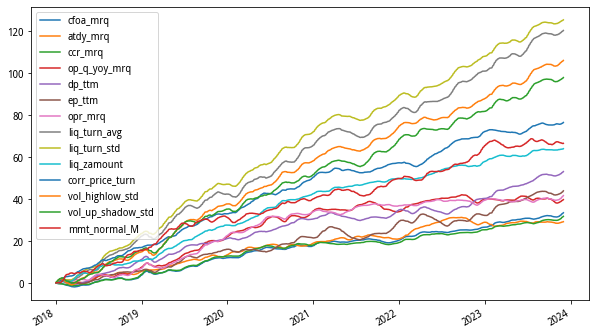

In [28]:
cumic(factor_names,ic_df)

In [29]:
ic_df.count()

cfoa_mrq             1436
atdy_mrq             1436
ccr_mrq              1436
op_q_yoy_mrq         1436
dp_ttm               1436
pe_ttm               1436
ep_ttm               1436
opr_mrq              1436
liq_turn_avg         1436
liq_turn_std         1436
liq_zamount          1436
corr_price_turn      1436
vol_highlow_std      1436
vol_up_shadow_std    1436
mmt_normal_M         1436
mmt_normal_A         1436
dtype: int64

In [30]:
ic_df[factor_names].corr()

,cfoa_mrq,atdy_mrq,ccr_mrq,op_q_yoy_mrq,dp_ttm,ep_ttm,opr_mrq,liq_turn_avg,liq_turn_std,liq_zamount,corr_price_turn,vol_highlow_std,vol_up_shadow_std,mmt_normal_M
cfoa_mrq,1.000000,0.352047,0.952343,0.500103,0.510254,0.333741,0.498129,0.295494,0.296776,0.173665,0.089734,0.364585,0.364493,-0.064311
atdy_mrq,0.352047,1.000000,0.324952,0.759117,-0.088307,-0.175322,0.434233,-0.158719,-0.149892,-0.003272,-0.045020,-0.086441,-0.067163,-0.249561
ccr_mrq,0.952343,0.324952,1.000000,0.489240,0.498684,0.281295,0.554364,0.285644,0.276104,0.130242,0.101235,0.320418,0.321570,-0.070076
op_q_yoy_mrq,0.500103,0.759117,0.489240,1.000000,0.069186,-0.092419,0.752340,-0.118078,-0.077511,0.157763,0.040915,0.001763,0.009794,-0.162048
dp_ttm,0.510254,-0.088307,0.498684,0.069186,1.000000,0.804817,0.197975,0.616531,0.575218,0.113278,0.135828,0.628065,0.648463,0.020194
ep_ttm,0.333741,-0.175322,0.281295,-0.092419,0.804817,1.000000,-0.065427,0.647463,0.598109,0.055369,0.056218,0.651336,0.697946,0.085768
opr_mrq,0.498129,0.434233,0.554364,0.752340,0.197975,-0.065427,1.000000,-0.078640,-0.023365,0.238589,0.171888,0.026967,0.007087,-0.078693
liq_turn_avg,0.295494,-0.158719,0.285644,-0.118078,0.616531,0.647463,-0.078640,1.000000,0.973085,0.272179,0.406571,0.870173,0.885643,0.207583
liq_turn_std,0.296776,-0.149892,0.276104,-0.077511,0.575218,0.598109,-0.023365,0.973085,1.000000,0.459122,0.498658,0.885961,0.874645,0.285246
liq_zamount,0.173665,-0.003272,0.130242,0.157763,0.113278,0.055369,0.238589,0.272179,0.459122,1.000000,0.615353,0.420410,0.322735,0.423887


### 3 多重共共线性检验
#### 3.1 相关性统计
##### 3.1.1 因子IC相关性统计

In [31]:
# 热力图    
def hot_corr(name,ic_df):
    """
    :param name: 因子名称 -> list 
    :param ic_df: ic序列表 -> dataframe 
    :return fig: 热力图 -> plt
    """
    ax = plt.subplots(figsize=(len(name), len(name)))#调整画布大小
    ax = sns.heatmap(ic_df[name].corr(),vmin=0.4, square=True, annot= True,cmap = 'Blues')   #annot=True 表示显示系数
    plt.title('Factors_IC_CORRELATION')
    # 设置刻度字体大小
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

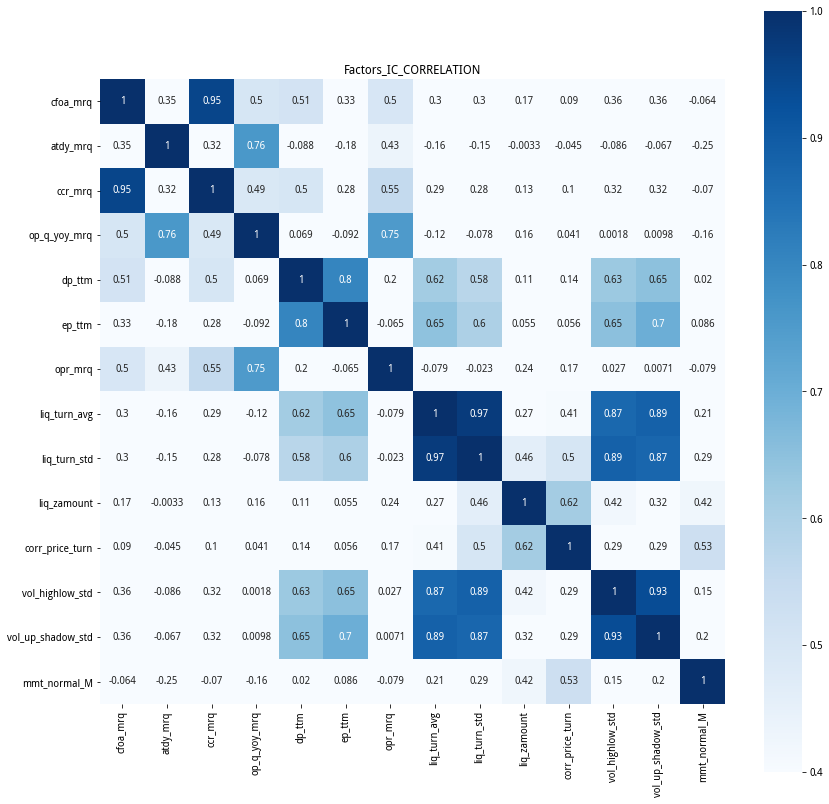

In [32]:
# ic序列相关性
hot_corr(factor_names,ic_df)

##### 3.1.2 因子值相关性统计

In [33]:
# 因子值相关性
value_df = pd.DataFrame(index = value_dict[factor_names[0]].stack().index)
for i in factor_names:
    value_df[i] = value_dict[i].stack()
value_df.dropna()
value_df.columns = factor_names
value_df.head()

cfoa_mrq  atdy_mrq   ccr_mrq  op_q_yoy_mrq  \
datetime   order_book_id                                               
2018-01-02 000010.XSHE    0.127313  1.826817  0.099466      1.706450   
           000011.XSHE    0.660750  2.135730  0.296694      1.494684   
           000016.XSHE   -1.935531 -0.632822 -0.929461      1.262487   
           000018.XSHE   -1.434536 -1.264260 -0.699314     -0.282902   
           000036.XSHE    0.360274  0.572447  0.320169     -0.683542   

                            dp_ttm    ep_ttm   opr_mrq  liq_turn_avg  \
datetime   order_book_id                                               
2018-01-02 000010.XSHE   -1.142389 -1.005930  1.694795     -0.969004   
           000011.XSHE    0.688768  0.687125  0.678643     -1.133183   
           000016.XSHE   -1.553907 -1.445950 -1.132690      0.136408   
           000018.XSHE    0.534118  1.398157 -0.505902     -0.168539   
           000036.XSHE    1.878261  1.762445  1.466957      0.033555   

                          liq_turn_std  liq_zamount  corr_price_turn  \
datetime   order_book_id                                               
2018-01-02 000010.XSHE       -0.592612     0.303908        -0.671786   
           000011.XSHE       -0.736401     0.400212        -0.662591   
           000016.XSHE       -0.018221    -0.457035         0.064075   
           000018.XSHE        0.080227     1.030297         2.210190   
           000036.XSHE       -0.066872    -0.394273        -1.103284   

                          vol_highlow_std  vol_up_shadow_std  mmt_normal_M  
datetime   order_book_id                                                    
2018-01-02 000010.XSHE          -0.273014          -0.652485     -1.595369  
           000011.XSHE           0.719661          -0.094730     -0.500454  
           000016.XSHE          -0.815398          -0.718698      0.739026  
           000018.XSHE           0.452594           1.325303      2.104322  
           000036.XSHE           0.589852           0.763878     -0.826386

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5]),
 [Text(0, 0.5, 'cfoa_mrq'),
  Text(0, 1.5, 'atdy_mrq'),
  Text(0, 2.5, 'ccr_mrq'),
  Text(0, 3.5, 'op_q_yoy_mrq'),
  Text(0, 4.5, 'dp_ttm'),
  Text(0, 5.5, 'ep_ttm'),
  Text(0, 6.5, 'opr_mrq'),
  Text(0, 7.5, 'liq_turn_avg'),
  Text(0, 8.5, 'liq_turn_std'),
  Text(0, 9.5, 'liq_zamount'),
  Text(0, 10.5, 'corr_price_turn'),
  Text(0, 11.5, 'vol_highlow_std'),
  Text(0, 12.5, 'vol_up_shadow_std'),
  Text(0, 13.5, 'mmt_normal_M')])

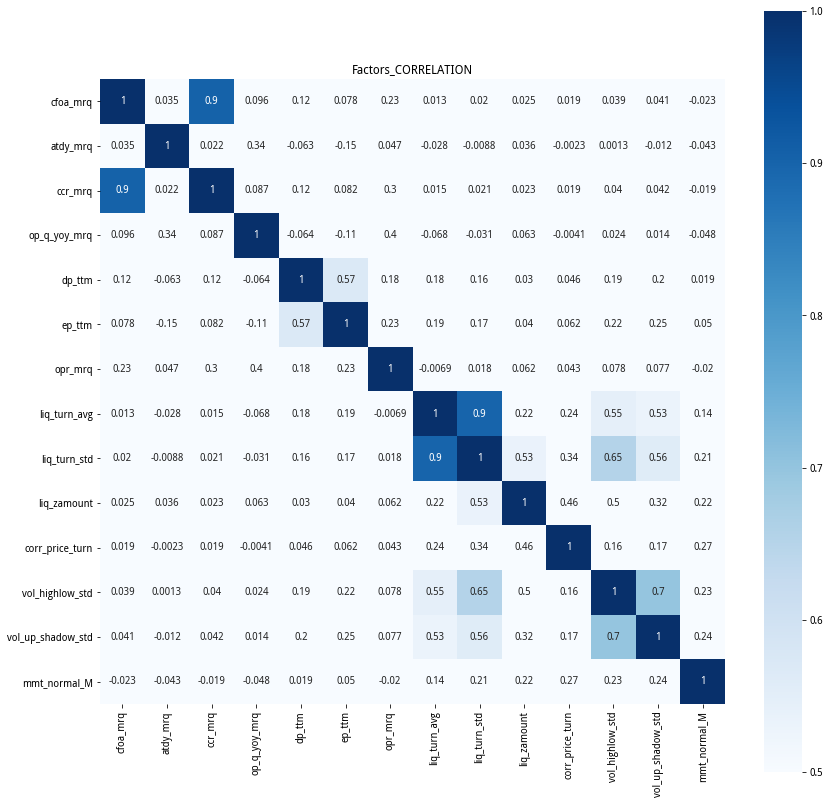

In [34]:
ax = plt.subplots(figsize=(len(factor_names), len(factor_names)))#调整画布大小
ax = sns.heatmap(value_df.corr(),vmin= 0.5, square=True, annot= True,cmap = 'Blues')#画热力图   annot=True 表示显示系数
plt.title('Factors_CORRELATION')
# 设置刻度字体大小
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

#### 3.2 VIF检验

In [35]:
# VIF检验
ic_df_pass = ic_df[factor_names]
VIF = {}
for i in tqdm(ic_df_pass.columns.tolist()):
    y = ic_df_pass[i]
    x = ic_df_pass.drop(i,axis = 1)
    VIF[i] = 1 / (1 - sm.OLS(y.astype(float),x.astype(float),hasconst=False, missing='drop').fit().rsquared)

VIF = pd.DataFrame([VIF]).T
VIF.columns = ['VIF']
VIF.sort_values(by = 'VIF',ascending=False)

100%|██████████| 14/14 [00:00<00:00, 18.69it/s]


,VIF
liq_turn_std,158.527928
liq_turn_avg,138.905308
vol_highlow_std,20.192527
vol_up_shadow_std,18.182978
ccr_mrq,17.698732
cfoa_mrq,17.180468
liq_zamount,10.394941
op_q_yoy_mrq,5.975306
dp_ttm,5.615578
ep_ttm,4.796727


### 4 多重共线性处理

#### 4.1 高相关性处理

In [36]:
ic_df

,cfoa_mrq,atdy_mrq,ccr_mrq,op_q_yoy_mrq,dp_ttm,pe_ttm,ep_ttm,opr_mrq,liq_turn_avg,liq_turn_std,liq_zamount,corr_price_turn,vol_highlow_std,vol_up_shadow_std,mmt_normal_M,mmt_normal_A
2018-01-02,-0.040049,0.026274,-0.057295,0.077683,0.017050,0.084000,0.047890,-0.017192,0.162641,0.169681,0.056851,0.109976,0.149268,0.216571,0.100840,-0.036012
2018-01-03,-0.020370,0.043507,-0.033100,0.094093,0.026106,0.102977,0.062662,0.021613,0.170135,0.163077,0.031751,0.069126,0.172163,0.205246,0.079633,0.001155
2018-01-04,-0.013019,0.038896,-0.019235,0.093146,0.040125,0.131741,0.104044,0.058634,0.185951,0.164234,-0.015246,0.081762,0.165180,0.206337,0.014726,0.034853
2018-01-05,-0.016134,0.048566,-0.015651,0.108350,0.044327,0.109330,0.087910,0.057285,0.140188,0.105196,-0.058442,0.048303,0.106781,0.167035,-0.056493,0.061102
2018-01-08,-0.026645,0.049309,-0.020937,0.093721,0.051230,0.102189,0.074818,0.043941,0.137555,0.107091,-0.046589,0.051310,0.097491,0.155889,-0.039391,0.040996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
def corr_line(ic_df,low = 0.8,high = 1):
    ## 高相关性分析
    factor_corr = pd.DataFrame(ic_df.dropna().corr().stack())
    factor_corr.columns = ['CORRELATION']
    factor_corr.index.names = ['factor_a','factor_b']
    factor_corr = factor_corr[(factor_corr > low) & (factor_corr < high)].dropna().drop_duplicates()

    return factor_corr

In [38]:
high_data = corr_line(ic_df[factor_names])
high_data

CORRELATION
factor_a        factor_b                      
cfoa_mrq        ccr_mrq               0.952343
dp_ttm          ep_ttm                0.804817
liq_turn_avg    liq_turn_std          0.973085
                vol_highlow_std       0.870173
                vol_up_shadow_std     0.885643
liq_turn_std    vol_highlow_std       0.885961
                vol_up_shadow_std     0.874645
vol_highlow_std vol_up_shadow_std     0.934581

In [39]:
orth_wait = list(set(high_data.index.get_level_values(0)) | set(high_data.index.get_level_values(1)))
orth_wait

['dp_ttm',
 'cfoa_mrq',
 'vol_up_shadow_std',
 'vol_highlow_std',
 'liq_turn_avg',
 'ccr_mrq',
 'liq_turn_std',
 'ep_ttm']

In [40]:
corr_group = {0:['cfoa_mrq','ccr_mrq'],
              1:['liq_turn_avg','liq_turn_std','vol_highlow_std','vol_up_shadow_std'],
              2:['dp_ttm','ep_ttm']}

In [41]:
for i in list(corr_group.keys()):
    del_factors = ic_summary.loc[corr_group[i],'IR'].sort_values(ascending = False).index.tolist()[1:]
    for j in del_factors:
        factor_names.remove(j)
factor_names

['cfoa_mrq',
 'atdy_mrq',
 'op_q_yoy_mrq',
 'dp_ttm',
 'opr_mrq',
 'liq_turn_std',
 'liq_zamount',
 'corr_price_turn',
 'mmt_normal_M']

#### 4.2 中相关性处理

In [42]:
def corr_line(ic_df,low = 0.65,high = 1):
    ## 高相关性分析
    factor_corr = pd.DataFrame(ic_df.dropna().corr().stack())
    factor_corr.columns = ['CORRELATION']
    factor_corr.index.names = ['factor_a','factor_b']
    factor_corr = factor_corr[(factor_corr > low) & (factor_corr < high)].dropna().drop_duplicates()

    return factor_corr

In [43]:
middle_data = corr_line(ic_df[factor_names])
middle_data

,,CORRELATION
factor_a,factor_b,
atdy_mrq,op_q_yoy_mrq,0.759117
op_q_yoy_mrq,opr_mrq,0.752340


(array([0.5, 1.5, 2.5]),
 [Text(0, 0.5, 'opr_mrq'),
  Text(0, 1.5, 'atdy_mrq'),
  Text(0, 2.5, 'op_q_yoy_mrq')])

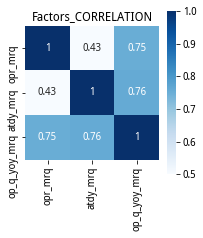

In [44]:
orth_wait = list(set(middle_data.index.get_level_values(0)) | set(middle_data.index.get_level_values(1)))
ax = plt.subplots(figsize=(len(orth_wait), len(orth_wait)))#调整画布大小
ax = sns.heatmap(ic_df[orth_wait].corr(),vmin=0.5, square=True, annot= True,cmap = 'Blues')#画热力图   annot=True 表示显示系数
plt.title('Factors_CORRELATION')
# 设置刻度字体大小
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

In [45]:
corr_group = {0:['opr_mrq','atdy_mrq','op_q_yoy_mrq']}

##### 4.2.1 正交化处理

In [46]:
# 正交化函数
def orth_quick(orth_list,value_dict):
        # 正交化函数
    def orth_function(orth,time_list):
        orth = orth.dropna()
        factor_names = orth.columns.tolist()
        factors_orthogonal = pd.DataFrame(columns = factor_names,index = orth.index)
        # 数据运行
        factors_orthogonalization = pd.DataFrame()
        for i in time_list:
            try:
                factor = orth.loc[i]
                factor = factor[factor_names]
                M = (factor.shape[0]-1)* np.cov(factor.T.astype(float))   # 矩阵M
                D,U = np.linalg.eig(M)                                    # 获取特征值和特征向量
                U = np.mat(U)                                             # 转换为np中的矩阵
                d = np.mat(np.diag(D**(-0.5)))                            # 对特征根元素开(-0.5)指数
                S = U * d * U.T                                           # 获取过度矩阵S
                factors_orthogonal_mat = np.mat(factor) * S               # 获取对称正交矩阵
                factors_orthogonal.loc[i].loc[factor.index,factor_names] = factors_orthogonal_mat   # 矩阵转为dataframe
            except:
                pass
        return factors_orthogonal
    
    # 确定最早和最晚的起止日期    
    common_start = max(value_dict[factor_name].index[0] for factor_name in orth_list)
    common_end = min(value_dict[factor_name].index[-1] for factor_name in orth_list)
    date_list = pd.to_datetime(get_trading_dates(common_start,common_end))
    # 计算股票名称的交集
    common_stocks = set.intersection(*[set(value_dict[factor_name].columns) for factor_name in orth_list])

    df = pd.DataFrame(index = pd.MultiIndex.from_product([date_list, common_stocks], names=["date", "order_book_id"]))

    for k in orth_list:
        df[k] = value_dict[k].stack()

    df = orth_function(df,date_list)
    df = df.sum(axis = 1).unstack('order_book_id')
    df = df.sub(df.mean(axis=1), axis=0).div(df.std(axis=1), axis=0)
    
    return df

In [47]:
factor_orth = orth_quick(corr_group[0],value_dict)
orth_name = 'orth(' + '+'.join(corr_group[0]) + ')'
ic,performance = Quick_Factor_Return_N_IC(factor_orth,20,index_item,orth_name)

{'name': 'orth(opr_mrq+atdy_mrq+op_q_yoy_mrq)', 'IC mean': 0.0341, 'IC std': 0.0746, 'IR': 0.4569, 'IC>0': 0.6616, 'ABS_IC>2%': 0.8099, 't_stat': 17.314}


In [48]:
# 合成后的因子表现会由于合成前的单个因子
ic_summary.loc[corr_group[0]]

,IC mean,IC std,IR,IC>0,ABS_IC>2%,t_stat
name,,,,,,
opr_mrq,0.0290,0.0664,0.4369,0.6421,0.7591,16.5549
atdy_mrq,0.0203,0.0535,0.3806,0.6525,0.7674,14.4230
op_q_yoy_mrq,0.0277,0.0751,0.3688,0.6414,0.8182,13.9747


In [49]:
# 加入合成因子IC
ic_df[orth_name] = ic

# 加入合成因子值
value_dict[orth_name] = factor_orth

# 合成队列剔除原始因子，加入合成因子
for i in orth_wait:
    factor_names.remove(i)

factor_names += [orth_name]
factor_names

['cfoa_mrq',
 'dp_ttm',
 'liq_turn_std',
 'liq_zamount',
 'corr_price_turn',
 'mmt_normal_M',
 'orth(opr_mrq+atdy_mrq+op_q_yoy_mrq)']

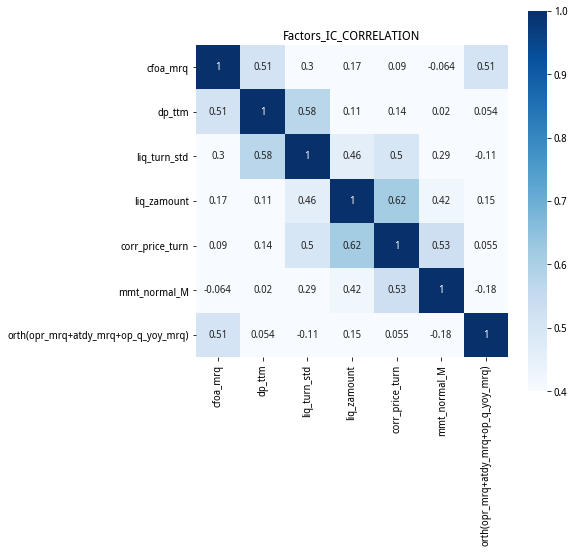

In [50]:
# ic序列相关性
hot_corr(factor_names,ic_df)

### 5 多因子合成

不同合成方法收益风险对比，参考《光大证券 EBQC因子综合质量因子》，更多合成方法可以参考《华泰金工 多因子合成方法》

课程的网站对应课件中均可下载。

#### 5.1 等权合成

In [51]:
ew_combo = pd.DataFrame()
for i in factor_names:
    ew_combo = ew_combo.add(value_dict[i],fill_value = 0)
ew_combo.to_pickle('ew_combo.pkl')

In [52]:
ic,performance = Quick_Factor_Return_N_IC(ew_combo,20,index_item,'ew_combo')

{'name': 'ew_combo', 'IC mean': 0.0907, 'IC std': 0.0815, 'IR': 1.113, 'IC>0': 0.8565, 'ABS_IC>2%': 0.9074, 't_stat': 42.1769}


In [56]:
ic_df[factor_names].mean()

cfoa_mrq                               0.023313
dp_ttm                                 0.036980
liq_turn_std                           0.087310
liq_zamount                            0.044555
corr_price_turn                        0.053269
mmt_normal_M                           0.046332
orth(opr_mrq+atdy_mrq+op_q_yoy_mrq)    0.034068
dtype: float64

In [55]:
ic_df[factor_names].mean()/ic_df[factor_names].std()

cfoa_mrq                               0.491345
dp_ttm                                 0.579463
liq_turn_std                           0.956969
liq_zamount                            0.831623
corr_price_turn                        0.831728
mmt_normal_M                           0.492838
orth(opr_mrq+atdy_mrq+op_q_yoy_mrq)    0.456900
dtype: float64

In [81]:
df = ew_combo
buy_list = get_buy_list(df,rank_n = 200)
df_weight = buy_list.div(buy_list.sum(axis = 1),axis = 0)
df_weight = df_weight.shift(1).dropna(how = 'all')
account_result = backtest(df_weight)
performance_cumnet,result = get_performance_analysis(account_result,benchmark_index = index_item)

100%|██████████| 73/73 [00:00<00:00, 89.79it/s]


,回测指标
策略累计收益,0.4488
策略年化收益,0.0662
基准累计收益,-0.1667
基准年化收益,-0.0310
阿尔法,0.0861
贝塔,0.8533
波动率,0.2124
夏普比率,0.1705
下行波动率,0.1622
索提诺比率,0.2234


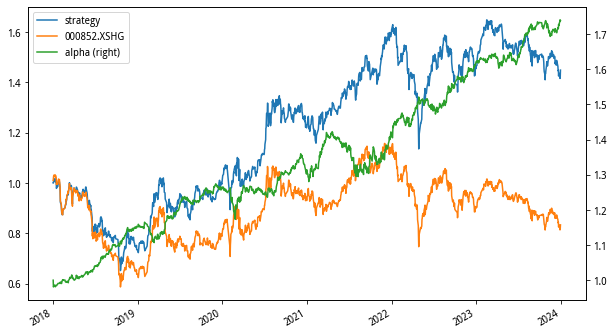

In [82]:
performance_cumnet.plot(secondary_y = 'alpha',figsize = (10,6))
pd.DataFrame([result],index = ['回测指标']).T

#### 5.2 ICIR加权

In [83]:
icir_combo_value = pd.DataFrame(index = value_dict[factor_names[0]].stack().index) 
for i in tqdm(factor_names):
    icir_combo_value[i] = value_dict[i].stack()

icir_combo_value.index.names = ['datetime','order_book_id']
icir_combo_value.sort_index(inplace = True)

100%|██████████| 7/7 [00:02<00:00,  2.71it/s]


In [84]:
icirw = (ic_df.rolling(240).mean()/ic_df.rolling(240).std())#.shift(20).dropna(how = 'all')
icirw.index.names = ['datetime']
icirw_combo = icir_combo_value.mul(icirw[factor_names],axis = 0).dropna(how = 'all').sum(axis = 1).unstack('order_book_id')
ic,performance = Quick_Factor_Return_N_IC(icirw_combo,20,index_item,'icirw_combo')

{'name': 'icirw_combo', 'IC mean': 0.0893, 'IC std': 0.0839, 'IR': 1.0643, 'IC>0': 0.8427, 'ABS_IC>2%': 0.9107, 't_stat': 36.4994}


100%|██████████| 60/60 [00:00<00:00, 82.91it/s]


,回测指标
策略累计收益,1.0817
策略年化收益,0.1669
基准累计收益,0.3532
基准年化收益,0.0658
阿尔法,0.0939
贝塔,0.8470
波动率,0.2101
夏普比率,0.6515
下行波动率,0.1613
索提诺比率,0.8487


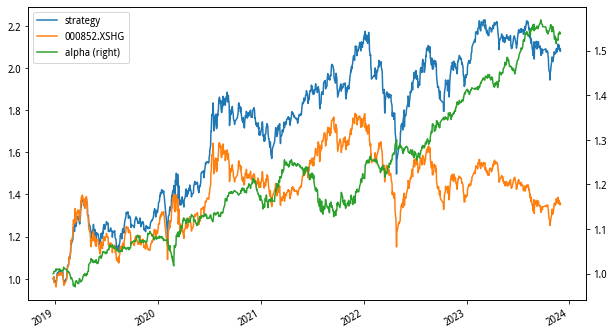

In [85]:
df = icirw_combo
buy_list = get_buy_list(df,rank_n = 200)
df_weight = buy_list.div(buy_list.sum(axis = 1),axis = 0)
df_weight = df_weight.shift(1).dropna(how = 'all')
account_result = backtest(df_weight)
performance_cumnet,result = get_performance_analysis(account_result,benchmark_index = index_item)

performance_cumnet.plot(secondary_y = 'alpha',figsize = (10,6))
pd.DataFrame([result],index = ['回测指标']).T

In [86]:
# icir加权后移动
icirw = (ic_df.rolling(240).mean()/ic_df.rolling(240).std()).shift(20).dropna(how = 'all')
icirw.index.names = ['datetime']
icirw_combo = icir_combo_value.mul(icirw[factor_names],axis = 0).dropna(how = 'all').sum(axis = 1).unstack('order_book_id')
ic,performance = Quick_Factor_Return_N_IC(icirw_combo,20,index_item,'icirw_combo')

{'name': 'icirw_combo', 'IC mean': 0.0836, 'IC std': 0.0849, 'IR': 0.9845, 'IC>0': 0.8299, 'ABS_IC>2%': 0.9039, 't_stat': 33.7625}


In [87]:
df_weight

order_book_id,000011.XSHE,000016.XSHE,000018.XSHE,000030.XSHE,000034.XSHE,000035.XSHE,000036.XSHE,000038.XSHE,000040.XSHE,000055.XSHE,...,688091.XSHG,688123.XSHG,688153.XSHG,688190.XSHG,688206.XSHG,688232.XSHG,688262.XSHG,688209.XSHG,603235.XSHG,002866.XSHE
datetime,,,,,,,,,,,,,,,,,,,,,
2018-12-26,NaN,0.005,NaN,NaN,NaN,NaN,0.005,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-27,NaN,0.005,NaN,NaN,NaN,NaN,0.005,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-28,NaN,0.005,NaN,NaN,NaN,NaN,0.005,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-02,NaN,0.005,NaN,NaN,NaN,NaN,0.005,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-03,NaN,0.005,NaN,NaN,NaN,NaN,0.005,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005,NaN
2023-11-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005,NaN
2023-11-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005,NaN


100%|██████████| 60/60 [00:00<00:00, 84.40it/s]


,回测指标
策略累计收益,0.7891
策略年化收益,0.1303
基准累计收益,0.2390
基准年化收益,0.0461
阿尔法,0.0786
贝塔,0.8461
波动率,0.2094
夏普比率,0.4790
下行波动率,0.1600
索提诺比率,0.6268


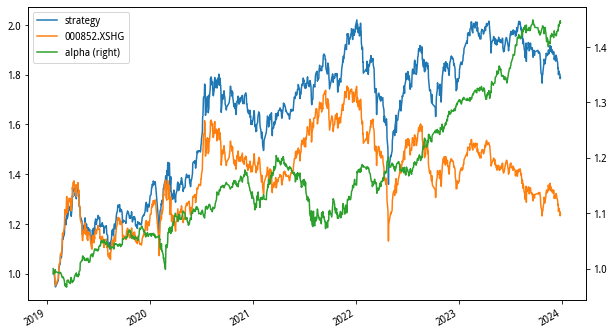

In [88]:
df = icirw_combo
buy_list = get_buy_list(df,rank_n = 200)
df_weight = buy_list.div(buy_list.sum(axis = 1),axis = 0)
df_weight = df_weight.shift(1).dropna(how = 'all')
account_result = backtest(df_weight)
performance_cumnet,result = get_performance_analysis(account_result,benchmark_index = index_item)

performance_cumnet.plot(secondary_y = 'alpha',figsize = (10,6))
pd.DataFrame([result],index = ['回测指标']).T

In [89]:
# 对比同期等权合成
ic,performance = Quick_Factor_Return_N_IC(ew_combo.loc[icirw_combo.index],20,index_item,'ew_combo')

{'name': 'ew_combo', 'IC mean': 0.0861, 'IC std': 0.0837, 'IR': 1.0287, 'IC>0': 0.8342, 'ABS_IC>2%': 0.9014, 't_stat': 35.277}


100%|██████████| 60/60 [00:00<00:00, 91.97it/s]


,回测指标
策略累计收益,0.8168
策略年化收益,0.1339
基准累计收益,0.2390
基准年化收益,0.0461
阿尔法,0.0819
贝塔,0.8448
波动率,0.2094
夏普比率,0.4965
下行波动率,0.1600
索提诺比率,0.6495


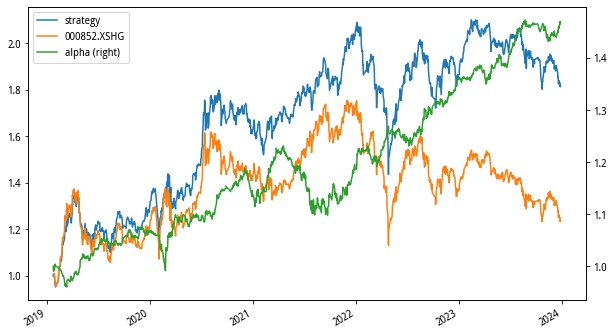

In [91]:
df = ew_combo.loc[icirw_combo.index]
buy_list = get_buy_list(df,rank_n = 200)
df_weight = buy_list.div(buy_list.sum(axis = 1),axis = 0)
df_weight = df_weight.shift(1).dropna(how = 'all')
account_result = backtest(df_weight)
performance_cumnet,result = get_performance_analysis(account_result,benchmark_index = index_item)

performance_cumnet.plot(secondary_y = 'alpha',figsize = (10,6))
pd.DataFrame([result],index = ['回测指标']).T